In [1]:
%matplotlib inline

In [20]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               rotation_range = 20, 
                               shear_range = 0.3, 
                               zoom_range = 0.3, 
                               horizontal_flip = True, 
                               preprocessing_function=preprocess_input, 
                               validation_split=0.2)

input_size = (224, 224)
train_generator = generator.flow_from_directory("./data/generator",
                                                target_size=input_size,
                                                batch_size=32,
                                                class_mode="categorical",
                                                subset='training')

valid_generator = generator.flow_from_directory("./data/generator",
                                                target_size=input_size,
                                                batch_size=32,
                                                class_mode="categorical",
                                                subset='validation')


Found 22618 images belonging to 10 classes.
Found 5648 images belonging to 10 classes.


W0807 13:37:14.183398 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:14.465398 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:14.766069 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:15.056322 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:15.340583 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:15.759874 140625774446400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 13:37:16.042863 140625

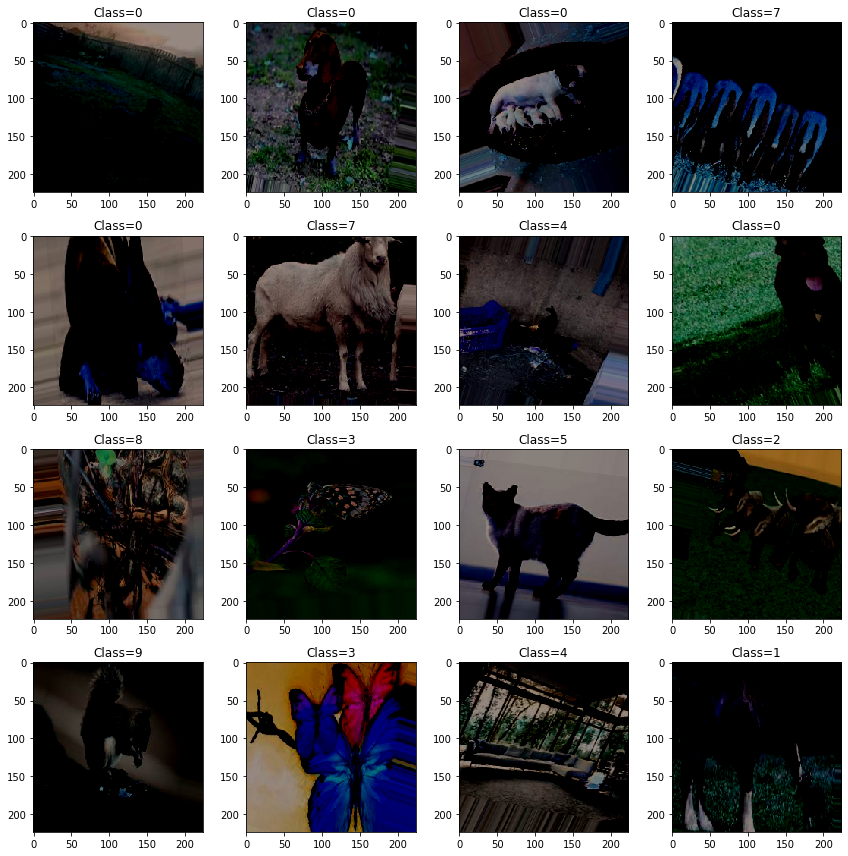

In [21]:
import numpy as np
import matplotlib.pylab as plt

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for ax in axs.flatten():
    img, label = train_generator.next()
    cls = np.argmax(label[0], axis=0)

    ax.imshow(img[0])
    ax.set_title("Class=%d" % cls)
    
plt.tight_layout()
plt.show()
    

In [33]:
from keras.applications.resnet50 import ResNet50

from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD

NUM_CLASSES = 10

K.clear_session()
resnet = ResNet50(weights="imagenet", include_top=False, pooling=None, input_shape=(input_size[0], input_size[1], 3))
for layer in resnet.layers:
    layer.trainable = False
    
# Build model from resnet50 output
x = resnet.output
x = Flatten()(x)

x = Dense(128, activation="relu", kernel_initializer="he_uniform")(x)
x = Dense(64, activation="relu", kernel_initializer="he_uniform")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=resnet.input, outputs=output)

opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()


/home/david.sullivan/anaconda3/envs/keras/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 16
epochs = 50

model.fit_generator(
                train_generator,
                samples_per_epoch = nb_train_samples,
                epochs = epochs,
                validation_data = valid_generator,
                nb_val_samples = nb_validation_samples,
                callbacks = [early])


/home/david.sullivan/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/david.sullivan/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=128, validation_steps=466)`


Epoch 1/50
 68/128 [==============>...............] - ETA: 3:43 - loss: 1.3227 - acc: 0.5708